In [13]:
# Blueprint of the class VAR 
#requirements: 
import pandas as pd
import numpy as np
import logging 
from core.analysis_base_class import Analysis
from analysis import timeline_analysis as ta
from statsmodels.tsa.api import VAR as var 
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.tsatools import detrend
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score

logger = logging.getLogger(__name__)


class VAR(Analysis):
    """ When creating var model we first generate a timeline in the form of pandas df. Then feed it to VAR method in statsmodels.
        We can save the names of the variables(queries) this way so no need of mapping (var to name) on the later stages,
        awesome plotting functionality and just comfortable to work with for everyone. 
    """
     
    def __init__(self):  
        """creates variables: 
            @self.flag_stationarity = boolean of whether assumptions checks for VAR were run ## delete?!
        """
        self.flag_stationarity = False
        
    
    def fit(self,queries,timefield,granularity,querytype="count",nlags=None, **kwargs):
        """ @queries  = what do you want to query from ES ? eg queries = ['Trump','Hillary']
            @timefield = what field do you want to use to get the dates/timeline from ? 'META.ADDED'
            @granularity = 'day'/'week'/'month' etc 
            @nlags -  number of lags to consider, if none - rely on statsmodels to choose lag for you 
            
            Possible kwargs to be added later:
                @level = confidence level for all your test (!) , default = 5%
                @from_time - 
                @to_time -
                @do_assump_check = True/False    ##
                @do_transfomations = True/False   ##
                @max_order_diff = maximum order of differencing, default = 2  
                @max_order_detrend = maximum order of detredning, default = 2
                @stationarity_kpss = True/False, False is default, hence you do ADF test
        """
        self.max_order_diff = kwargs.get('max_order_diff',2)
        self.max_order_detrend = kwargs.get('max_order_detrend',2)
        self.stationarity_kpss = kwargs.get('stationarity_kpss',False)
        self.level = kwargs.get('level','5%')
        self.from_time = kwargs.get('from_time',None)
        self.to_time = kwargs.get('to_time',None)
        
        timeline = ta.timeline_generator()
        df_raw = timeline.analyse(queries=queries,timefield = timefield, granularity = granularity,
                                 from_time=self.from_time,to_time=self.to_time)
        df_raw.index = df_raw.timestamp
        df_raw = df_raw.drop('timestamp',axis=1) 
        self.df_raw = df_raw
        
        # Do the stationarity modifications
        logger.warning("Before fitting, I automatically check stationarity assumption") 
        check_1 = self.test_assumptions(df_raw)    
        
        # Fit the VAR model 
        if self.flag_stationarity == True: 
            logger.warning("You are good to go")
        else: 
            logger.warning("Be warned: some time series are still non-stationary")
        self.model = var(self.df)
        self.result = self.model.fit(nlags,ic='fpe')   # mle, I specify the information criteria here 
        
        #Lets do diagnostics: 
        check_2 = self.diagnostics()
        
        return # what do we return? 

    def test_assumptions(self, df, level='5%', **kwargs):
        """ This method checks if df_raw needs to be made stationary; if stationary this becomes df 
            which you then use for the fit method; if your raw df is not stationary then we do transfomations 
            such as differencing or detrending. 
                        
        @df - 'active' df which we might want to modify
        @level -  this is the level you are testing your asusmptions on. 
                  NOTE: when test_assump called from fit method level is set by kwarg or default is 5%
        @test_type - either adf or kpss
        """
        self.diff_order  = 0
        self.detrend_order = 0
        def _adf_test(df):
            """ 
            H_0: the observed time series is stationary 
            Returns: dataframe of summary of the test 
            """
            summary_adf = pd.DataFrame(columns=['ADF_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = adfuller(series)
                dic = {'ADF_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[4]['1%'],'Critical_val_5%':result[4]['5%'],
                       'Critical_val_10%':result[4]['10%']}
                summary_adf = summary_adf.append(dic,ignore_index=True)
            summary_adf.set_index(df.columns,inplace=True)  

            return summary_adf 
        
        def _kpss_test(df):
            """ 
            H_0: there is a unit root in time series, hence stochastic trend with drift, hence non-stationary
            Returns: dataframe of summary of the test
            """
            summary_kpss = pd.DataFrame(columns=['KPSS_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = kpss(series)
                dic = {'KPSS_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[3]['1%'],'Critical_val_5%':result[3]['5%'],
                       'Critical_val_10%':result[3]['10%']}
                summary_kpss = summary_kpss.append(dic,ignore_index=True)
            summary_kpss.set_index(df.columns,inplace=True)  

            return summary_kpss
        
        def _stationary(df):
            """ 
            For each time series return the result of the check - return in created dataframe ?
            Uses by default adf_ test, but if you want kpss test you have to give an argument
            """
            lvl = float(self.level[:-1])/100 
            stat_flag = True                    # if test failed, we assume we need to take action 
            if self.stationarity_kpss == False:
                self.summary_adf = _adf_test(df)
                for i in df.columns:
                    adf_flag = lvl > self.summary_adf.loc[i,'p-value']
                    if (adf_flag == False):
                        stat_flag = False 
                    print("For {} stationarity is satisfied: ADF - {}".format(i,adf_flag)) ## PRINT (!)
            else:
                self.summary_kpss = _kpss_test(df)
                for i in df.columns:
                    kpss_flag = lvl < self.summary_kpss.loc[i,'p-value']
                    if (kpss_flag == False):
                        stat_flag = False 
                    print("For {} stationarity is satisfied: KPSS - {}".format(i,kpss_flag))  ## 
            
            return stat_flag 
        
        def differencing(df, order=1):
            """ If there is no stationarity: try differencing
            """  
            helped = False   ## boolean check if differencing helped 
            def _perform_differencing():
            # Perform differencing:  
                df_diff = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    series = series.diff(order)
                    df_diff[name] = series.dropna(axis=0)
                
                return _stationary(df_diff), df_diff   
            
            stat_check_after_diff, df_diff = _perform_differencing()
            print('Differencing helped?')   ##            
            print(stat_check_after_diff)   ##
            
            ## if differencing helped update self.df => self.df = df_diff 
            if stat_check_after_diff == True: 
                self.df = df_diff       ## CREATING FINAL DF for the first time if differncing helped
                helped = True   
                
            return helped
        
        def detrending(df, order=1):
            """ If there is no stationarity: differencing did not help - detrend
               (!) does not work nicely with time series where there is a lot of zeros and high volatility :(
            """     
            helped = False  ## boolean check if detrending helped
            def _perform_detrending():
            # Perform detrending:  
                df_res = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    res = detrend(series,order)
                    df_res[name] = series.dropna(axis=0)
                
                return _stationary(df_res), df_res  
            
            stat_check_after_detrend, df_detrended = _perform_detrending()
            print('Detrending helped?')       ##            
            print(stat_check_after_detrend)   ##
            
            ## if detrending helped update self.df => self.df = df_diff 
            if stat_check_after_detrend == True: 
                self.df = df_detrended             # CREATING FINAL DF for the first time if detrending helped
                helped = True   
            
            return helped
        
        # Run the check on df_raw and do transformations if necessery 
        self.flag_stationarity = _stationary(df)
        
        #self.flag_stationarity  = False                       ## Delete, just for testing ##
        
        if self.flag_stationarity == True: 
            self.df = self.df_raw               # if no transoformation needed - just use df_raw
            print('No need in transforms as stationarity is {}'.format(self.flag_stationarity)) ##
        else: 
            # (1) start the iterative procedure of differencing
            for i in range(1,self.max_order_diff + 1):
                self.diff_order = i                           # uncomment this
                diff_helped = differencing(df,order=i)
                if diff_helped == True:
                    #print(self.df)
                    self.flag_stationarity = diff_helped 
                    break 
            # (2) if differencing did not help do detrending 
            
            #self.flag_stationarity  = False                    ##Delete, just for testing ##
            
            if self.flag_stationarity == False: 
                for i in range(1,self.max_order_detrend + 1):
                    # self.detrend_order = i                    #uncomment this 
                    detrend_helped = detrending(df,order=i)
                    if detrend_helped == True:
                        #print(self.df)
                        self.flag_stationarity = detrend_helped 
                        break
        # write smth for the case when nothing helped, already written a logger warning in fit though
       
    def diagnostics(self,level='5%',**kwargs):
        
        """ Possible diagnostics: 
                1. serial/autocorrelation of the residuals check via Ljung_Box test
                2. residual acf plot 
            
            @level = what confidence level to use in test Ljung_Box. 
                     NOTE: when test_assump called from fit method level is set by kwarg or default is 5%
       
            Possible kwargs to be added later:
                @do_plot = boolean, show the acf plot of the residuals, default = False
        """
        residuals = self.result.resid      
        do_plot = kwargs.get('do_plot',False)
        self.lag = int((len(m1.result.params) - 1 ) / len(m1.df.columns)) # Fishy way to find out lag 
        
        def _ljbox_test():
            """H_0: the data are independently distributed, not enough evidence to supoprt serial corr
            Returns: dataframe of summary of the test 
            """
            summary_ljb = pd.DataFrame(columns=['ljbvalue','p-value'])
            for name in self.df.columns:
                series = residuals[name]
                result = acorr_ljungbox(series,lags=self.lag)
                dic = {'ljbvalue':result[0][self.lag-1],'p-value':result[1][self.lag-1]}
                summary_ljb = summary_ljb.append(dic,ignore_index=True)
            self.summary_ljb = summary_ljb.set_index(self.df.columns) 
            
            lvl = float(self.level[:-1])/100
            res_white_flag = True                # if test failed, we assume we need to take action 
            for i in self.df.columns:
                not_white = lvl > self.summary_ljb.loc[i,'p-value']
                if (not_white == True):
                    res_white_flag = False 

            return res_white_flag
        
        def _plot_res_acf(do_plot): 
            if do_plot:
                for name in self.df.columns:
                    series = residuals[name]
                    print("Residuals autocorelation plot for {}".format(name))
                    plot_acf(series, lags=self.lag)
                    pyplot.show()
                    
                return # _plot_res_act 
        
        res_check = _ljbox_test()
        _plot_res_acf(do_plot)           
        
        return res_check # for diag 
        
       
        
    def granger(self,ts_1,ts_2,level,lag):
        """The Null hypothesis for grangercausalitytests is that the time series in the second column,
            x2, does NOT Granger cause the time series in the first column, x1.
            
            @ts_1 - time series which is assumed to not granger cause ts_2 (regressor)
            @ts_2 - time series which is assumed to be not granger cause ts_1 
            @level - confidence level of ssr f test 
            @lag - lag at which we want the test
        """
        array = self.df.iloc[:,[ts_2-1,ts_1-1]].values
        
        #Granger causality table for the last call of self.granger()
        table = grangercausalitytests(array,maxlag=lag,verbose=False)[lag][0]
        self.granger_table = pd.DataFrame.from_dict(table,orient='index')
        old_names = list(self.granger_table.columns)
        new_names = ['F-val', 'p-val', 'df_denom', 'df_num']
        self.granger_table.rename(columns=dict(zip(old_names, new_names)), inplace=True)
        
        result = grangercausalitytests(array,maxlag=lag,verbose=False)[lag][0]['ssr_ftest']
        
        granger_flag = result[1] < float(level[:-1])/100          
       
        
        return granger_flag # for granger 

    def plot(self, plot_type=None, lag = 1):
        """ Ploting graphs for df """
        def lag_scatter():
            """ Scatter plot: Lag plots are used to check if a data set or time series is random. Random data 
            should not exhibit any structure in the lag plot. Non-random structure implies that the underlying 
            data are not random."""
            for name in self.df.columns:
                series = self.df[name]
                print("Lag plot where y is {}".format(name))
                lag_plot(series,lag)
                pyplot.show()    

            return ##
        
        def line_plot():
            
            for name in self.df.columns:
                series = self.df[name]
                series.plot(legend=True)
                pyplot.show()
            return ##
    
        def autocorrelation_plot():
            """Autocorrelation plot"""
            for name in self.df.columns:
                series = self.df[name]
                print("Autocorelation plot for {}".format(name)) 
                plot_acf(series, lags=lag)
                pyplot.show()
            
        if plot_type == None:
            lag_scatter() 
            line_plot()
            autocorrelation_plot()
        if (plot_type == ('line')):
            line_plot()
        if (plot_type == ('lag')):
            lag_scatter()
        if (plot_type == ('autocorrelation')):
            autocorrelation_plot()
        
        return ## 
    
    def interpretation(self, **kwargs):
        """
        - Summary table
        - Data preprocessing: 
            - detrended_order
            - differenced_order 
        """
        print("Summary for VAR model")
        print(self.result.summary())
        print("Pre-processing perforemed:")
        print("1) Differencing of {} order".format(self.diff_order))
        print("2) Detrending of {} order".format(self.detrend_order))
        print("Model fit:")
        print("3) Number of lags {} ".format(self.lag))
       
        return  # for interpetation 
        
    def quality(self, **kwargs):
        """
        - Outliers (??) - there will be no significant outliers with stationarity: outliers detection
          for stationary time-series is too advanced topic. 
        
        - white noise residuals - this is done by diagnostics so I call diagnostic here
        - (From me:) VAR lag order selection table fto see which lags could also be tried  
        - if R2 below some benchmark give a message 'proceed with caution' 
        """
        # Check if residuals are white noise 
        print("1) Residuals of the model are White Noise: {} ".format(self.diagnostics()))
        
        # Almost manually calculating R2 :D 
        predicted = self.df.values[:-m1.lag,:]  - self.result.resid.values
        true = self.df.values[:-m1.lag,:]
        self.r2 = r2_score(true,predicted)
        print("2) R-squared is {} ".format(self.r2)) 
        
        return # for quality 
     










In [7]:
import inca 
from statsmodels.tsa.stattools import q_stat
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [8]:
m1 = VAR()

In [9]:
m_fit = m1.fit(queries=['d','h','y'], timefield = 'META.ADDED', granularity = 'day')

For 1. d    stationarity is satisfied: ADF - True
For 2. h    stationarity is satisfied: ADF - False
For 3. y    stationarity is satisfied: ADF - False
For 1. d    stationarity is satisfied: ADF - True
For 2. h    stationarity is satisfied: ADF - True
For 3. y    stationarity is satisfied: ADF - True
Differencing helped?
True


In [10]:
test = var(m1.df)
results =test.fit(2)
# results.summary()
# m1.df.values[:-m1.lag,:]  - m1.result.resid.values
# len(results.params) - 1
# test.predict(params=results.params)
# type(results.params)
# m1.model.select_order()

In [12]:
#m1.model.select_order(verbose=False)['bic']
m1.interpretation()
# m1.quality()

Summary for VAR model
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Dec, 2017
Time:                     09:58:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    23.3722
Nobs:                     97.0000    HQIC:                   22.4709
Log likelihood:          -1416.08    FPE:                3.16229e+09
AIC:                      21.8592    Det(Omega_mle):     1.84903e+09
--------------------------------------------------------------------
Results for equation 1. d   
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -8.716519        11.134426           -0.783           0.436
L1.1. d            0.214526         0.227214            0.944           0.348
L1.2. h            1.003135         0.671124    

In [240]:
m1.granger(ts_1=2,ts_2=1,level='5%',lag=2)
#m1.granger_table
#grangercausalitytests(m1.df.iloc[:,0:1],maxlag=2)

False

In [238]:
m1.diagnostics()
#m1.diagnostics('1%')
#m1.summary_ljb

True

In [141]:
m1.result.resid.iloc[:,1].values

array([  1.40503172e+01,  -7.39490377e+00,  -2.23277067e+00,
         2.17672293e+01,   0.00000000e+00,   1.76722933e+00,
        -4.27435864e-15,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,  -2.23277067e+00,
        -2.23277067e+00,  -2.23277067e+00,   7.76722933e+00])

In [101]:
m1.result.resid_corr

array([[ 1.        ,  0.82367053,  0.85961797],
       [ 0.82367053,  1.        ,  0.9895712 ],
       [ 0.85961797,  0.9895712 ,  1.        ]])

In [100]:
m1.result.resid_acorr()

array([[[ 1.        ,  0.82367053,  0.85961797],
        [ 0.82367053,  1.        ,  0.9895712 ],
        [ 0.85961797,  0.9895712 ,  1.        ]],

       [[-0.00690914, -0.01077653, -0.00981867],
        [-0.00599101, -0.0898677 , -0.08370556],
        [-0.01248548, -0.09301561, -0.08641538]]])

In [176]:
acorr_ljungbox(m1.result.resid.iloc[:,0],lags=2,boxpierce=False)

#q_stat(acf(m1.result.resid.iloc[:,1]),nobs=len(m1.result.resid.iloc[:,1]))

(array([ 0.0012951 ,  0.01535185]), array([ 0.9712923 ,  0.99235346]))

In [86]:
m1.result.test_normality()
pyplot.show()

Normality skew/kurtosis Chi^2-test
   Test statistic   Critical Value          p-value  df
-------------------------------------------------------
       258.496368         9.487729            0.000   4
H_0: data generated by normally-distributed process
Conclusion: reject H_0 at 5.00% significance level


In [98]:
#m1.diagnostics()

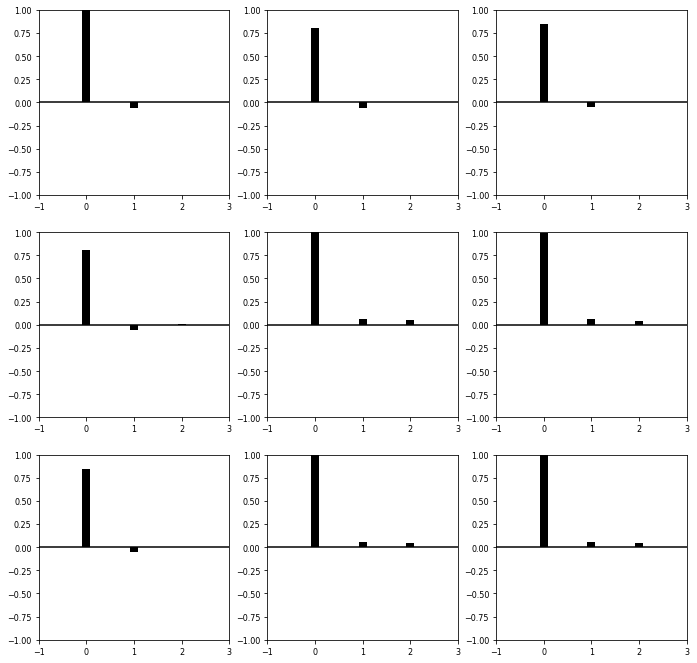

In [57]:
m1.result.resid
autocor = m1.result.acorr() #theoretical autocorrelation function
#print(autocor)
m1.result.plot_acorr(2)
pyplot.show()   

In [ ]:
def _kpss_test(df):
            """ 
            H_0: there is a unit root in time series, hence stochastic trend with drift, hence non-stationary
            Returns: dataframe of summary of the test
            """
            summary_kpss = pd.DataFrame(columns=['KPSS_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = kpss(series)
                dic = {'KPSS_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[3]['1%'],'Critical_val_5%':result[3]['5%'],
                       'Critical_val_10%':result[3]['10%']}
                summary_kpss = summary_kpss.append(dic,ignore_index=True)
            summary_kpss.set_index(df.columns,inplace=True)  

            return summary_kpss

In [8]:
#LOAD SOME TEST DATA 

In [2]:
import zipfile
import elasticsearch
import elasticsearch.helpers
import json
import argparse
from json import JSONDecodeError

In [5]:
def load_documents(filename, endpoint):
    es = elasticsearch.Elasticsearch(endpoint)
    n = 0
    with zipfile.bz2.open(filename) as f:
        batch = []
        while 1:
            try:
                line = f.readline()
            except EOFError:
                break
            except TypeError:
                continue

            try:
                doc = json.loads(line.decode())
            except JSONDecodeError:
                continue

            batch.append(doc)

            if len(batch)>100:
                n += 1
                print("Uploaded batch {n}".format(n=n))
                elasticsearch.helpers.bulk(es, batch)
                batch = []

        if batch: elastic.search.helpers.bulk(es,batch)

    print("done")
            
if __name__ == "__main__":
    
    #parser = argparse.ArgumentParser()
    #parser.add_argument("-e","--endpoint", default='localhost:9200')
    #parser.add_argument("-f","--filename", default='ftn_dump.json.bz2')

    #arguments = parser.parse_args()

    #load_documents(arguments.filename, arguments.endpoint)
    load_documents('ftn_dump.json.bz2', 'localhost:9200' )

Uploaded batch 1
Uploaded batch 2
Uploaded batch 3
Uploaded batch 4
Uploaded batch 5
Uploaded batch 6
Uploaded batch 7
Uploaded batch 8
Uploaded batch 9
Uploaded batch 10
Uploaded batch 11
Uploaded batch 12
Uploaded batch 13
Uploaded batch 14
Uploaded batch 15
Uploaded batch 16
Uploaded batch 17
Uploaded batch 18
Uploaded batch 19
Uploaded batch 20
Uploaded batch 21
Uploaded batch 22
Uploaded batch 23
Uploaded batch 24
Uploaded batch 25
Uploaded batch 26
Uploaded batch 27
Uploaded batch 28
Uploaded batch 29
Uploaded batch 30
Uploaded batch 31
Uploaded batch 32
Uploaded batch 33
Uploaded batch 34
Uploaded batch 35
Uploaded batch 36
Uploaded batch 37
Uploaded batch 38
Uploaded batch 39
Uploaded batch 40
Uploaded batch 41
Uploaded batch 42


ConnectionTimeout: ConnectionTimeout caused by - ReadTimeoutError(HTTPConnectionPool(host='localhost', port=9200): Read timed out. (read timeout=10))